In [202]:
# 1.) Installing the required functions
!pip install pandas
!pip install matplotlib
!pip install seaborn

# Importing the required Libraries
import pandas as pd
import numpy as np
import re
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import time




In [203]:
# Load the CSV file into a pandas DataFrame
df = pd.read_csv('Csv_file.csv')

# Check the structure of the DataFrame
print("CSV file loaded successfully. Here's a preview of the data:")
print(df.head())  # Print the first few rows of the dataset

# Check for missing values in the dataset
print("\nMissing values in the dataset:")
print(df.isnull().sum())

# Check the columns available in the dataset
print("\nColumns available in the dataset:")
print(df.columns)

# Confirm the number of rows and columns in the dataset
print(f"\nThe dataset contains {df.shape[0]} rows and {df.shape[1]} columns.")



CSV file loaded successfully. Here's a preview of the data:
                              CompanyName  CompanyNumber RegAddress.CareOf  \
0                  BULLDOG MINI SKIPS LTD       15330909               NaN   
1                         BULLDOG LIMITED       09043007               NaN   
2                   BULLDOG MUSHROOMS LTD       08465312               NaN   
3  BULLDOG MUSICAL ENTERTAINMENTS LIMITED       01652098               NaN   
4   BULLDOG NETWORK (BOURNEMOUTH) LIMITED       04667818               NaN   

  RegAddress.POBox                          RegAddress.AddressLine1  \
0              NaN                          YARD 1, ARNOCK BUNGALOW   
1              NaN                                FORESTERS COTTAGE   
2              NaN                  C58-59 NEW COVENT GARDEN MARKET   
3              NaN                            5 RAVENSFIELD GARDENS   
4              NaN  FRP ADVISORY TRADING LIMITED, MOUNTBATTEN HOUSE   

   RegAddress.AddressLine2 RegAddress.PostTo

Column Overview:
['CompanyName', ' CompanyNumber', 'RegAddress.CareOf', 'RegAddress.POBox', 'RegAddress.AddressLine1', ' RegAddress.AddressLine2', 'RegAddress.PostTown', 'RegAddress.County', 'RegAddress.Country', 'RegAddress.PostCode', 'CompanyCategory', 'CompanyStatus', 'CountryOfOrigin', 'DissolutionDate', 'IncorporationDate', 'Accounts.AccountRefDay', 'Accounts.AccountRefMonth', 'Accounts.NextDueDate', 'Accounts.LastMadeUpDate', 'Accounts.AccountCategory', 'Returns.NextDueDate', 'Returns.LastMadeUpDate', 'Mortgages.NumMortCharges', 'Mortgages.NumMortOutstanding', 'Mortgages.NumMortPartSatisfied', 'Mortgages.NumMortSatisfied', 'SICCode.SicText_1', 'SICCode.SicText_2', 'SICCode.SicText_3', 'SICCode.SicText_4', 'LimitedPartnerships.NumGenPartners', 'LimitedPartnerships.NumLimPartners', 'URI', 'PreviousName_1.CONDATE', ' PreviousName_1.CompanyName', ' PreviousName_2.CONDATE', ' PreviousName_2.CompanyName', 'PreviousName_3.CONDATE', ' PreviousName_3.CompanyName', 'PreviousName_4.CONDATE'

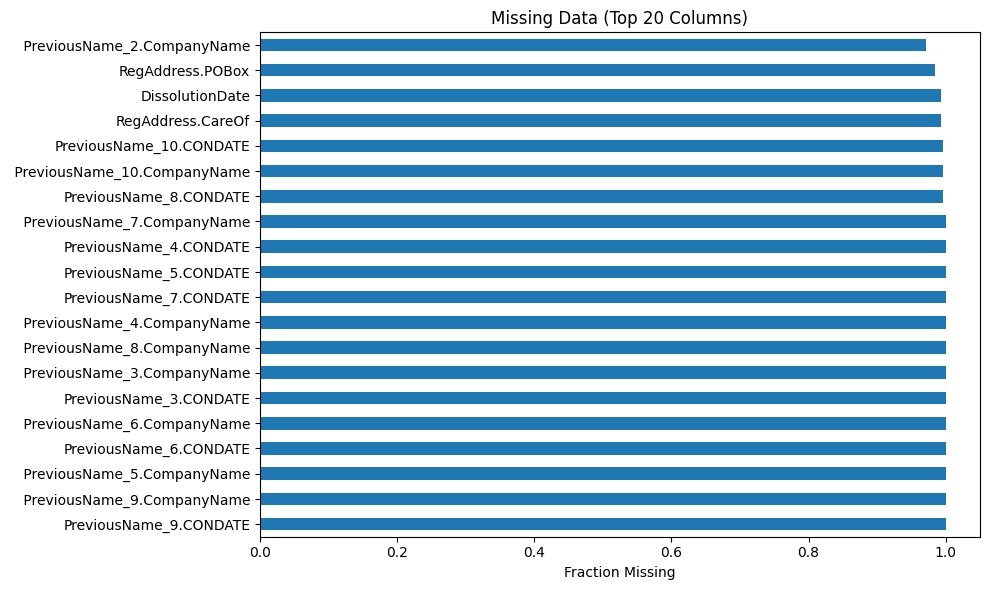

In [204]:
#3.) Initial profiling
print("Column Overview:")
print(df.columns.tolist())

print("\nMissing Values Summary:")
print(df.isnull().sum().sort_values(ascending=False))

print("\nDuplicate Records:")
print(df.duplicated().sum())

# Quick visualization of missing data
df.isnull().mean().sort_values(ascending=False).head(20).plot.barh(
    figsize=(10,6), title="Missing Data (Top 20 Columns)")
plt.xlabel("Fraction Missing")
plt.tight_layout()
plt.show()


In [205]:
# 5.) Normalize company names by removing extra spaces and making them lowercases removing extra spaces
def clean_name(name):
    if pd.isnull(name): return ""
    name = name.lower().strip()
    name = re.sub(r'[^a-z0-9 &]', '', name)
    return name

df['CleanCompanyName'] = df['CompanyName'].apply(clean_name)

# Clean postcodes
df['RegAddress.PostCode'] = df['RegAddress.PostCode'].str.upper().str.strip()

# Display first few rows to confirm cleaning
print("\nFirst 5 rows after cleaning:")
print(df[['CompanyName', 'CleanCompanyName', 'RegAddress.PostCode']].head())

print("\nCleaning complete.")



First 5 rows after cleaning:
                              CompanyName  \
0                  BULLDOG MINI SKIPS LTD   
1                         BULLDOG LIMITED   
2                   BULLDOG MUSHROOMS LTD   
3  BULLDOG MUSICAL ENTERTAINMENTS LIMITED   
4   BULLDOG NETWORK (BOURNEMOUTH) LIMITED   

                         CleanCompanyName RegAddress.PostCode  
0                  bulldog mini skips ltd            CM13 3TB  
1                         bulldog limited            RG26 5SW  
2                   bulldog mushrooms ltd             SW8 5JJ  
3  bulldog musical entertainments limited            KT19 0ST  
4     bulldog network bournemouth limited            SO15 2RP  

Cleaning complete.


In [206]:
# 6.) Drop duplicate companies based on cleaned name
df = df.drop_duplicates(subset='CleanCompanyName')
print("Shape after deduplication:", df.shape)


Shape after deduplication: (300, 56)


In [207]:
# API Query with Local Caching
API_KEY = "add your key here I have deleted mine before pushing to repo"
BASE_URL = "https://api.company-information.service.gov.uk/search/companies"
CACHE_DIR = "api_cache"
os.makedirs(CACHE_DIR, exist_ok=True)

def cached_query(name, cache_dir=CACHE_DIR):
    if not name:
        return {}

    safe_name = re.sub(r'[^\w\s-]', '', name.replace(' ', '_'))
    cache_file = os.path.join(cache_dir, f"{safe_name}.json")

    if os.path.exists(cache_file) and os.path.getsize(cache_file) > 0:
        try:
            with open(cache_file, 'r') as f:
                return json.load(f)
        except json.JSONDecodeError:
            print(f" Skipping invalid cache for: {name}")
            os.remove(cache_file)

    try:
        resp = requests.get(BASE_URL, auth=(API_KEY, ""), params={"q": name})
        if resp.status_code == 200:
            data = resp.json()
            if data.get('items'):
                first_result = data['items'][0]
                with open(cache_file, 'w') as f:
                    json.dump(first_result, f)
                return first_result
    except Exception as e:
        print(f"Error querying '{name}': {e}")

    return {}

# Run API queries
df['CH_Response'] = df['CleanCompanyName'].apply(cached_query)


In [208]:
def enrich_ch_data(data):
    if not data: return {}
    return {
        'CH_CompanyNumber': data.get('company_number'),
        'CH_CompanyStatus': data.get('company_status'),
        'CH_Address': data.get('address_snippet'),
        'CH_SICCodes': data.get('sic_codes', [])
    }

# Apply to the correct DataFrame: df
enriched = df['CH_Response'].apply(enrich_ch_data)
enriched_df = pd.json_normalize(enriched)

# Merge back into the original df
df = pd.concat([df, enriched_df], axis=1)

# sanity check
print(df[['CompanyName', 'CH_CompanyNumber', 'CH_CompanyStatus', 'CH_Address', 'CH_SICCodes']].head())


                              CompanyName CH_CompanyNumber CH_CompanyStatus  \
0                  BULLDOG MINI SKIPS LTD         15330909           active   
1                         BULLDOG LIMITED         01954910           active   
2                   BULLDOG MUSHROOMS LTD         08465312           active   
3  BULLDOG MUSICAL ENTERTAINMENTS LIMITED         01652098           active   
4   BULLDOG NETWORK (BOURNEMOUTH) LIMITED         04667818        dissolved   

                                          CH_Address CH_SICCodes  
0  Yard 1, Arnock Bungalow, Southend Arterial Roa...          []  
1  8 Church Green East, Redditch, Worcestershire,...          []  
2  C58-59 New Covent Garden Market, Nine Elms Lan...          []  
3  5 Ravensfield Gardens, Stoneleigh, Surrey, KT1...          []  
4  Frp Advisory Trading Limited, Mountbatten Hous...          []  


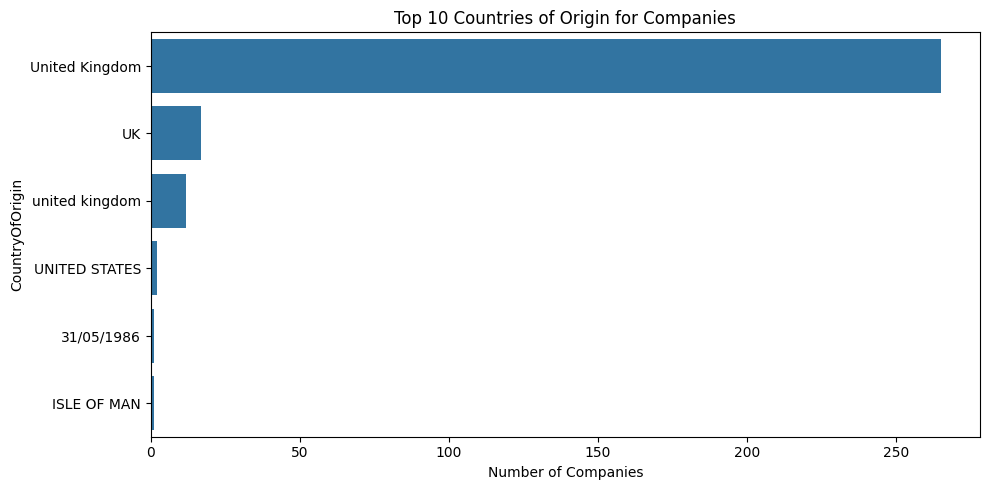

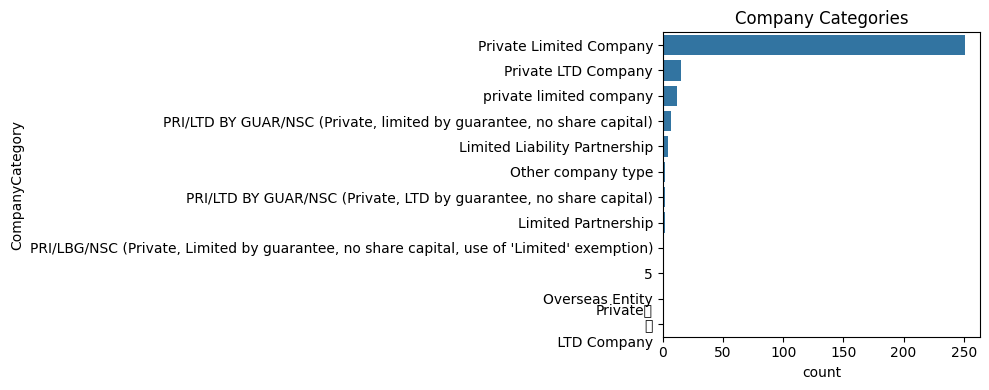

In [209]:
# Top Countries of Origin
if 'CountryOfOrigin' in df.columns and df['CountryOfOrigin'].notna().sum() > 0:
    top_countries = df['CountryOfOrigin'].value_counts().dropna().head(10)
    plt.figure(figsize=(10, 5))
    sns.barplot(y=top_countries.index, x=top_countries.values)
    plt.title("Top 10 Countries of Origin for Companies")
    plt.xlabel("Number of Companies")
    plt.tight_layout()
    plt.show()
else:
    print("'CountryOfOrigin' column is missing or empty.")

# Company Category Breakdown
if 'CompanyCategory' in df.columns and df['CompanyCategory'].notna().sum() > 0:
    plt.figure(figsize=(10, 4))
    sns.countplot(data=df, y='CompanyCategory', order=df['CompanyCategory'].value_counts().index)
    plt.title("Company Categories")
    plt.tight_layout()
    plt.show()
else:
    print("'CompanyCategory' column is missing or empty.")
